# A. Nhập dữ liệu

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import math # thư viện math

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_percentage_error #đo MAPE
from sklearn.metrics import mean_squared_error #MSE để tính RMSE

import warnings
warnings.filterwarnings("ignore")

In [2]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# đọc dữ liệu từ file csv
df_train = pd.read_csv('/content/drive/MyDrive/2025/data_goc/train.csv',parse_dates=['Date'])
df_test = pd.read_csv('/content/drive/MyDrive/2025/data_goc/test.csv',parse_dates=['Date'])

In [4]:
# Kích thước của tập train
print(f"Tập train bao gồm {df_train.shape[0]} dòng và {df_train.shape[1]} cột.")
# Kích thước của tập test
print(f"Tập test bao gồm {df_test.shape[0]} dòng và {df_test.shape[1]} cột.")

Tập train bao gồm 901561 dòng và 6 cột.
Tập test bao gồm 74682 dòng và 6 cột.


# B. Tiền xử lý dữ liệu

In [5]:
# Gom data có cùng ngày lại và tạo 1 data bao gồm 3 cột date, units và revenue
train_1= df_train.groupby('Date')[['Units','Revenue']].sum().reset_index()
test_1= df_test.groupby('Date')[['Units','Revenue']].sum().reset_index()

In [6]:
# Xử lý dữ liệu Tập Train
# Kiểm tra dữ liệu của cột 'Date'
train_1['Date'] = pd.to_datetime(train_1['Date'])
full_date_range_train = pd.date_range(start=train_1['Date'].min(), end=train_1['Date'].max(), freq='D')
missing_date_train = full_date_range_train.difference(train_1['Date'])
print(missing_date_train)

# Điền dữ liệu bị thiếu của các cột bằng dữ liệu của ngày hôm trước
train_1 = train_1.set_index('Date').reindex(full_date_range_train).reset_index()
train_1.rename(columns={'index': 'Date'}, inplace=True)
train_1.fillna(method='ffill', inplace=True)

DatetimeIndex(['2010-07-30', '2010-08-13', '2010-08-27', '2010-09-30',
               '2010-10-13', '2010-11-09', '2010-11-16', '2010-11-30',
               '2010-12-01', '2010-12-25',
               ...
               '2019-05-02', '2019-07-02', '2019-10-01', '2019-12-01',
               '2020-03-01', '2020-03-02', '2020-05-02', '2020-07-02',
               '2020-09-30', '2020-11-30'],
              dtype='datetime64[ns]', length=116, freq=None)


In [7]:
# Xử lý dữ liệu Tập Test
# Kiểm tra dữ liệu của cột 'Date'
test_1['Date'] = pd.to_datetime(test_1['Date'])
full_date_range_test = pd.date_range(start=test_1['Date'].min(), end=test_1['Date'].max(), freq='D')
missing_date_test = full_date_range_test.difference(train_1['Date'])
print(missing_date_test)

# Điền dữ liệu bị thiếu của các cột bằng dữ liệu của ngày hôm trước
test_1 = test_1.set_index('Date').reindex(full_date_range_test).reset_index()
test_1.rename(columns={'index': 'Date'}, inplace=True)
test_1.fillna(method='ffill', inplace=True)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', length=547, freq='D')


In [8]:
# Gom data có cùng ngày lại và tạo 1 data chỉ có 2 cột date và Units
train_units= train_1.groupby('Date')['Units'].sum().reset_index()
test_units= test_1.groupby('Date')['Units'].sum().reset_index()

# Gom data có cùng ngày lại và tạo 1 data chỉ có 2 cột date và revenue
train_revenue= train_1.groupby('Date')['Revenue'].sum().reset_index()
test_revenue= test_1.groupby('Date')['Revenue'].sum().reset_index()

In [9]:
# set index
train_units = train_units.set_index('Date')
test_units = test_units.set_index('Date')

train_revenue = train_revenue.set_index('Date')
test_revenue = test_revenue.set_index('Date')

In [10]:
# Kích thước của tập train
print(f"Tập train bao gồm {train_revenue.shape[0]} dòng và {train_revenue.shape[1]} cột.")
# Kích thước của tập test
print(f"Tập test bao gồm {test_revenue.shape[0]} dòng và {test_revenue.shape[1]} cột.")

Tập train bao gồm 3834 dòng và 1 cột.
Tập test bao gồm 547 dòng và 1 cột.


# C. Feature Engineering

## Thêm các feature về thời gian

In [11]:
# Tạo ra các thuộc tính dựa trên time series index
def create_features(df):
  df = df.copy()
  df['Year'] = df.index.year
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Day_of_year'] = df.index.dayofyear
  df['WeekDay'] = df.index.dayofweek

  return df

In [12]:
train_revenue = create_features(train_revenue)
test_revenue = create_features(test_revenue)

train_units = create_features(train_units)
test_units = create_features(test_units)

## Áp dụng Trung Bình Trượt (Moving Average)

### Revenue

In [13]:
def apply_moving_averages(df):
    df["revenue_MA_7"] = df["Revenue"].rolling(window=7).mean()
    df["revenue_MA_15"] = df["Revenue"].rolling(window=15).mean()
    df["revenue_MA_30"] = df["Revenue"].rolling(window=30).mean()
    df["revenue_MA_60"] = df["Revenue"].rolling(window=60).mean()
    df.fillna(method="bfill", inplace=True)
    return df

train_revenue = apply_moving_averages(train_revenue)
test_revenue = apply_moving_averages(test_revenue)

### Unit Sold

In [14]:
def apply_moving_averages_2(df):
    df["unit_MA_7"] = df["Units"].rolling(window=7).mean()
    df["unit_MA_15"] = df["Units"].rolling(window=15).mean()
    df["unit_MA_30"] = df["Units"].rolling(window=30).mean()
    df["unit_MA_60"] = df["Units"].rolling(window=60).mean()
    df.fillna(method="bfill", inplace=True)
    return df

train_units = apply_moving_averages_2(train_units)
test_units = apply_moving_averages_2(test_units)

# C. Xây dựng mô hình XGB

In [15]:
def xgb(x_train,y_train,x_test,y_test):
  # Tinh chỉnh tham số với GridSearchCV
  param_grid = {
      'n_estimators': [100, 200, 500, 1000],
      'learning_rate': [0.01, 0.05, 0.1],
      'max_depth': [3, 5],
      'subsample': [0.8, 1.0]
  }

  xgb = XGBRegressor(random_state=42)
  grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
  grid_search.fit(X_train, y_train)

  # Huấn luyện mô hình tốt nhất
  best_model = grid_search.best_estimator_
  best_model.fit(X_train, y_train)

  # Dự đoán
  y_pred = best_model.predict(X_test)
  return y_pred

In [16]:
def evaluate_model(model_name, y_test, y_pred, results_list):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Lưu kết quả vào danh sách
    results_list.append({
        'Model': 'XGB with ' + model_name,
        'R^2': r2,
        'RMSE': rmse,
        'MAPE': mape
    })

results_revenue = []
results_unitsold = []
result_1 = []

# I. Dự đoán trên chuỗi gốc

### Revenue

In [17]:
ma_target = "Revenue"
X_train, y_train = train_revenue.drop(columns=[ma_target]), train_revenue[ma_target]
X_test, y_test = test_revenue.drop(columns=[ma_target]), test_revenue[ma_target]

In [18]:
rev_org = xgb(X_train, y_train,X_test, y_test)
evaluate_model('Revenue_org',y_test,rev_org,results_revenue)

### Unit Sold

In [19]:
ma_target = "Units"
X_train, y_train = train_units.drop(columns=[ma_target]), train_units[ma_target]
X_test, y_test = test_units.drop(columns=[ma_target]), test_units[ma_target]

In [20]:
unit_org = xgb(X_train, y_train,X_test, y_test)
evaluate_model('UnitSold_org',y_test,unit_org,results_unitsold)

# II. Dự đoán trên chuỗi đã làm mịn

## A. MA7

### Revenue

In [21]:
ma_target = "revenue_MA_7"
X_train, y_train = train_revenue.drop(columns=[ma_target]), train_revenue[ma_target]
X_test, y_test = test_revenue.drop(columns=[ma_target]), test_revenue[ma_target]

In [22]:
rev_MA7 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('Revenue_MA7',y_test,rev_MA7,results_revenue)

### Unit Sold

In [23]:
ma_target = "unit_MA_7"
X_train, y_train = train_units.drop(columns=[ma_target]), train_units[ma_target]
X_test, y_test = test_units.drop(columns=[ma_target]), test_units[ma_target]

In [24]:
unit_MA7 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('UnitSold_MA7',y_test,unit_MA7,results_unitsold)

## B. MA15

### Revenue

In [25]:
ma_target = "revenue_MA_15"
X_train, y_train = train_revenue.drop(columns=[ma_target]), train_revenue[ma_target]
X_test, y_test = test_revenue.drop(columns=[ma_target]), test_revenue[ma_target]

In [26]:
rev_MA15 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('Revenue_MA15',y_test,rev_MA15,results_revenue)

### Unit Sold

In [27]:
ma_target = "unit_MA_15"
X_train, y_train = train_units.drop(columns=[ma_target]), train_units[ma_target]
X_test, y_test = test_units.drop(columns=[ma_target]), test_units[ma_target]

In [28]:
unit_MA15 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('UnitSold_MA15',y_test,unit_MA15,results_unitsold)

## C. MA30

### Revenue

In [29]:
ma_target = "revenue_MA_30"
X_train, y_train = train_revenue.drop(columns=[ma_target]), train_revenue[ma_target]
X_test, y_test = test_revenue.drop(columns=[ma_target]), test_revenue[ma_target]

In [30]:
rev_MA30 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('Revenue_MA30',y_test,rev_MA30,results_revenue)

### Unit Sold

In [31]:
ma_target = "unit_MA_30"
X_train, y_train = train_units.drop(columns=[ma_target]), train_units[ma_target]
X_test, y_test = test_units.drop(columns=[ma_target]), test_units[ma_target]

In [32]:
unit_MA30 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('UnitSold_MA30',y_test,unit_MA30,results_unitsold)

## D. MA60

### Revenue

In [33]:
ma_target = "revenue_MA_60"
X_train, y_train = train_revenue.drop(columns=[ma_target]), train_revenue[ma_target]
X_test, y_test = test_revenue.drop(columns=[ma_target]), test_revenue[ma_target]

In [34]:
rev_MA60 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('Revenue_MA60',y_test,rev_MA60,results_revenue)

### Unit Sold

In [35]:
ma_target = "unit_MA_60"
X_train, y_train = train_units.drop(columns=[ma_target]), train_units[ma_target]
X_test, y_test = test_units.drop(columns=[ma_target]), test_units[ma_target]

In [36]:
unit_MA60 = xgb(X_train, y_train,X_test, y_test)
evaluate_model('UnitSold_MA60',y_test,unit_MA60,results_unitsold)

# Kết quả các mô hình

## Revenue

In [37]:
results_df_revenue = pd.DataFrame(results_revenue)
print("=== Kết quả dự đoán Revenue ===")
print(results_df_revenue)

=== Kết quả dự đoán Revenue ===
                   Model       R^2           RMSE      MAPE
0   XGB with Revenue_org  0.467913  786152.057746  0.924485
1   XGB with Revenue_MA7  0.907887  165481.364804  0.120215
2  XGB with Revenue_MA15  0.953315   92540.258062  0.069738
3  XGB with Revenue_MA30  0.941037   90640.682810  0.071222
4  XGB with Revenue_MA60  0.900974  103975.025717  0.073627


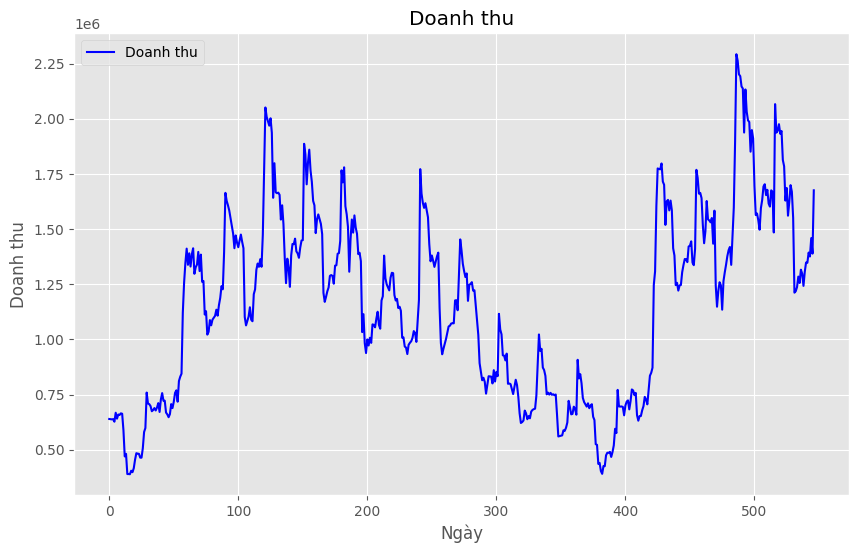

In [49]:
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(10,6))
plt.plot(rev_MA15, color='blue', label='Doanh thu')
plt.title('Doanh thu')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()
plt.show()

## Unit Sold

In [38]:
results_df_unitsold = pd.DataFrame(results_unitsold)
print("=== Kết quả dự đoán Unit Sold ===")
print(results_df_unitsold)

=== Kết quả dự đoán Unit Sold ===
                    Model       R^2       RMSE      MAPE
0   XGB with UnitSold_org  0.522787  94.047607  1.029027
1   XGB with UnitSold_MA7  0.898729  21.664799  0.128628
2  XGB with UnitSold_MA15  0.954408  11.467620  0.071497
3  XGB with UnitSold_MA30  0.944444  10.974414  0.059401
4  XGB with UnitSold_MA60  0.952074   8.960770  0.049266


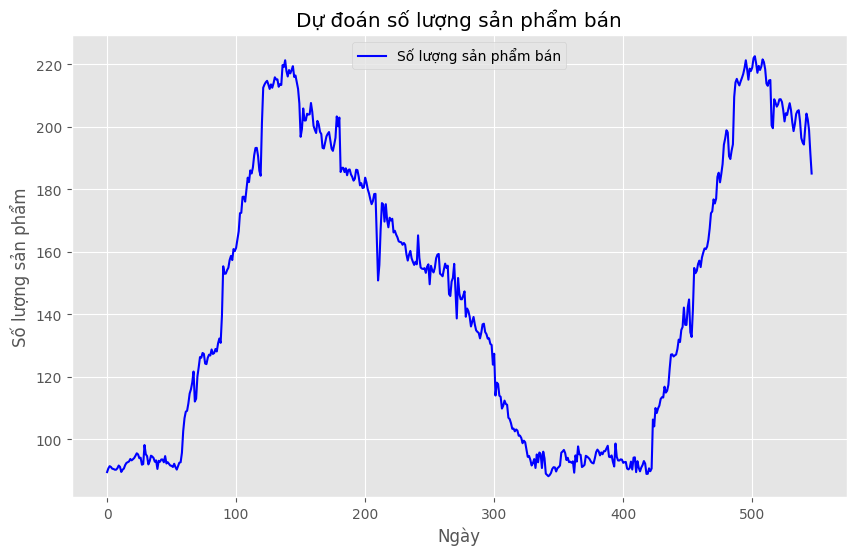

In [48]:
# Vẽ biểu đồ của mô hình có kết quả tốt nhất
plt.figure(figsize=(10,6))
plt.plot(unit_MA60, color='blue', label='Số lượng sản phẩm bán')
plt.title('Số lượng sản phẩm bán')
plt.xlabel('Ngày')
plt.ylabel('Số lượng sản phẩm')
plt.legend()
plt.show()

# Dự đoán tương lai (T7/2022 - T12/2023)

## Revenue

In [39]:
# Kết hợp tập dữ liệu train và test
full_revenue = pd.concat([train_revenue, test_revenue], axis=0)
full_revenue_1 = full_revenue.copy()
full_revenue.drop(columns=['Revenue','revenue_MA_7', 'revenue_MA_30', 'revenue_MA_60'], inplace=True)

# Thiết lập biến mục tiêu
ma_target = "revenue_MA_15"
X_full_train = full_revenue.drop(columns=[ma_target])
y_full_train = full_revenue[ma_target]

# Tinh chỉnh tham số mô hình XGBoost
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_full_train, y_full_train)

# Lưu mô hình tốt nhất
best_xgb = grid_search.best_estimator_

# Tạo dữ liệu tương lai
future_dates = pd.date_range(start="2022-07-02", end="2023-12-31", freq='D')
future_data = pd.DataFrame(index=future_dates)

# Tạo đặc trưng thời gian cho tương lai
future_data = create_features(future_data)

# Lấy dữ liệu quá khứ để tính MA15
past_data = full_revenue[ma_target].copy().reset_index()
last_ma15_value = past_data[ma_target].iloc[-1]

future_data.reset_index(inplace=True)
future_data.rename(columns={'index': 'Date'}, inplace=True)

# Kết hợp dữ liệu
future_data = future_data.merge(past_data[['Date', ma_target]], on="Date", how="left")
future_data.fillna(method="ffill", inplace=True)
future_data[ma_target].fillna(last_ma15_value, inplace=True)

future_data.set_index('Date', inplace=True)

# Dự đoán Moving Average doanh thu
future_data_no_target = future_data.drop(columns=[ma_target], errors='ignore')
future_data["Predicted_MA_Revenue"] = best_xgb.predict(future_data_no_target)
# Chuyển từ MA15 sang doanh thu thực bằng cách tính ngược lại
future_data["Predicted_True_Revenue"] = future_data["Predicted_MA_Revenue"] * 15

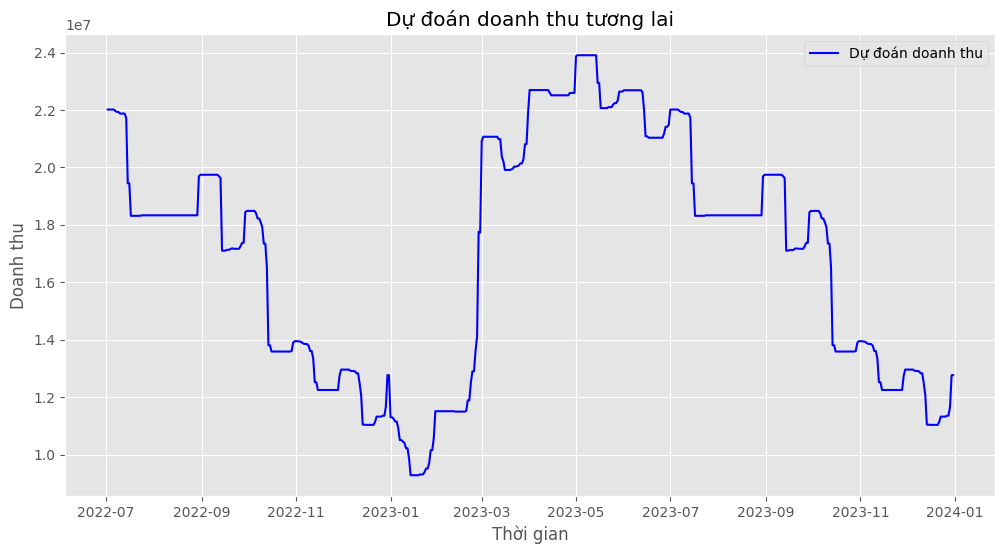

In [40]:
plt.figure(figsize=(12,6))
plt.plot(future_data["Predicted_True_Revenue"], color='blue', label='Dự đoán doanh thu')
plt.title('Dự đoán doanh thu tương lai')
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.legend()
plt.show()

## Unit Sold

In [41]:
# Kết hợp tập dữ liệu train và test
full_units = pd.concat([train_units, test_units], axis=0)
full_revenue_1 = full_units.copy()
full_units.drop(columns=['Units','unit_MA_7', 'unit_MA_15', 'unit_MA_30'], inplace=True)

# Thiết lập biến mục tiêu
ma_target = "unit_MA_60"
X_full_train = full_units.drop(columns=[ma_target])
y_full_train = full_units[ma_target]

# Tinh chỉnh tham số mô hình XGBoost
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_full_train, y_full_train)

# Lưu mô hình tốt nhất
best_xgb = grid_search.best_estimator_

# Tạo dữ liệu tương lai
future_dates = pd.date_range(start="2022-07-02", end="2023-12-31", freq='D')
future_data = pd.DataFrame(index=future_dates)

# Tạo đặc trưng thời gian cho tương lai
future_data = create_features(future_data)

# Lấy dữ liệu quá khứ để tính MA15
past_data = full_units[ma_target].copy().reset_index()
last_ma15_value = past_data[ma_target].iloc[-1]

future_data.reset_index(inplace=True)
future_data.rename(columns={'index': 'Date'}, inplace=True)

# Kết hợp dữ liệu
future_data = future_data.merge(past_data[['Date', ma_target]], on="Date", how="left")
future_data.fillna(method="ffill", inplace=True)
future_data[ma_target].fillna(last_ma15_value, inplace=True)
future_data.set_index('Date', inplace=True)

# Dự đoán Moving Average Unit sold
future_data_no_target = future_data.drop(columns=[ma_target], errors='ignore')
future_data["Predicted_MA_Units"] = best_xgb.predict(future_data_no_target)
# Chuyển từ MA15 sang doanh thu thực bằng cách tính ngược lại
future_data["Predicted_True_Units"] = future_data["Predicted_MA_Units"] * 60

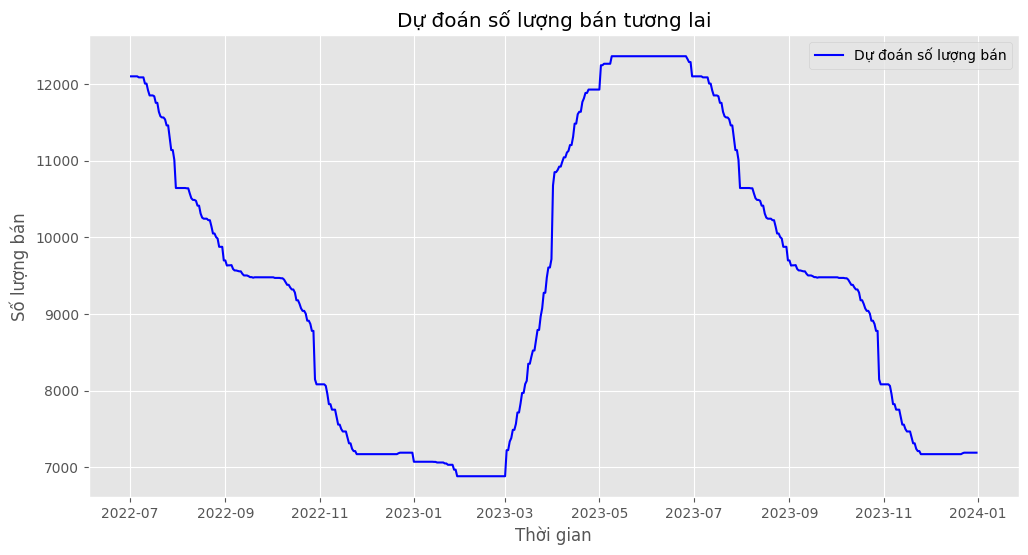

In [42]:
plt.figure(figsize=(12,6))
plt.plot(future_data["Predicted_True_Units"], color='blue', label='Dự đoán số lượng bán')
plt.title('Dự đoán số lượng bán tương lai')
plt.xlabel('Thời gian')
plt.ylabel('Số lượng bán')
plt.legend()
plt.show()